# Enhanced protein isoform characterization through long-read proteogenomics 
## Figure 2a and Supplementary Note Figure S1.3 S1.5
---
Ben Jordan | Gloria Sheynkman

In [1]:
from re import S
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
from matplotlib import rc
import os, sys
import matplotlib
import dataframe_image as dfi
import appris_helper


# currentdir = os.path.dirname(os.path.realpath(__file__))
# parentdir = os.path.dirname(currentdir)
# sys.path.append(parentdir)
import config

matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')

# file paths
sqanti_info_file = f"{config.PIPELINE_RESULTS_DIRECTORY}/transcriptome_summary/sqanti_isoform_info.tsv"

appris_info_file = '0_pre_analysis/appris_transcripts.tsv'
gencode_isoforms_file = '0_pre_analysis/gene_isoname_isbasic.tsv'
# protein_classification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/jurkat_unfiltered.protein_classification.tsv'
protein_classification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_filter/jurkat.classification_filtered.tsv'
# refined_metadata_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/hybrid_protein_database/jurkat_refined_high_confidence.tsv'
refined_metadata_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_gene_rename/jurkat_orf_refined_gene_update.tsv'

# read in files
appris_isonames = pd.read_table(appris_info_file)['isoname'].to_list()
sqanti_info = pd.read_table(sqanti_info_file)
sqanti_info['log2cpm'] = np.log2(sqanti_info['cpm'] + 1)
protein_classification = pd.read_table(protein_classification_file)
refined = pd.read_table(refined_metadata_file, usecols=['pb_accs', 'base_acc'])



### Figure S1.5: Breakdown of transcript isoforms by their novelty category. 

(Left) Number of transcript isoforms in each novelty classification category. (Middle) Breakdown of major (highest expressed for gene) transcript isoforms by novelty category. (Right) Breakdown of minor transcript isoforms by novelty category. Only transcripts greater than 1 CPM were used for the data in these plots. 

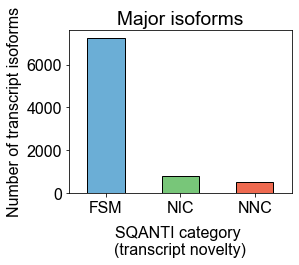

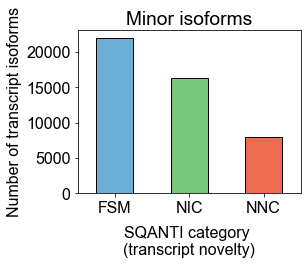

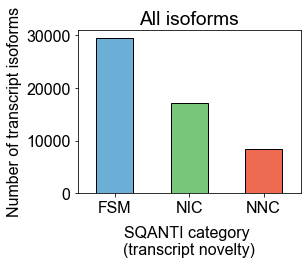

<Figure size 432x288 with 0 Axes>

In [2]:

sqanti_genes_over_one_transcript = sqanti_info.groupby('gene').filter(lambda x: len(x) > 1)
sqanti_1cpm = sqanti_info[sqanti_info['cpm'] > 1]
sqanti_genes_over_one_transcript = sqanti_genes_over_one_transcript[sqanti_genes_over_one_transcript['cpm'] > 1]
major_isoform = appris_helper.get_major_isoform(sqanti_genes_over_one_transcript)
minor_isoforms = appris_helper.get_minor_isoforms(sqanti_genes_over_one_transcript)

def plot_s1p5(major_isoform, minor_isoforms, all_isoforms):
    # plot sqanti categories for major isoforms, minor (0.1 cpm+), and all minor
    # get group of major isoforms
    major_grp = major_isoform.groupby('cat').size()
    minor_grp = minor_isoforms.groupby('cat').size()
    all_grp = all_isoforms.groupby('cat').size()
    # all_grp = major_grp + minor_grp
    # plot sqanti categories, broken down by major/minor isoform
    plt.clf()
    for (grp, name, title) in ((major_grp, 'major', 'Major isoforms'),
                            (minor_grp, 'minor', 'Minor isoforms'),
                            (all_grp,'all_isoforms','All isoforms')):
        # only plot fsm/nic/nnc, remove ism
        categories = ['FSM','NIC','NNC']
        colors = [config.sqanti_colors[cat] for cat in categories]
        grp_noism = grp[categories]
        grp_noism.plot(kind='bar', figsize=(4,3), edgecolor='black', color=colors, linewidth=1)
        plt.title(title)
        plt.xticks(rotation=0)
        plt.xlabel('SQANTI category \n(transcript novelty)', labelpad=10)
        plt.ylabel('Number of transcript isoforms')
        plt.savefig(f'plot/FigS1.5_bar_sqanti_cat_for_{name}_iso.pdf', bbox_inches='tight')
        plt.show()
        plt.clf()
        
        grp = (grp
            .reset_index()
            .rename(columns={'cat':'sqanti_cat', 0:'count'})
        )
        
        grp['total'] = grp['count'].sum()
        grp['percent'] = grp['count'] / grp['total'] * 100
        grp.to_csv(f'stats/FigS1.5_sqanti_cats_{name}_iso.tsv', sep='\t', index=None)
        
plot_s1p5(major_isoform, minor_isoforms, sqanti_1cpm)

### Supplementary Fig. 2: Generation and characterization of candidate protein isoform sequences from long-read RNA-seq data. 
 
a, Transcript abundance distributions for known (FSM) versus novel transcript isoforms (NIC, NNC). 

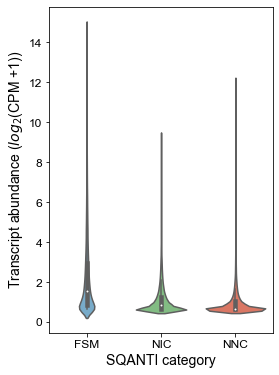

<Figure size 432x288 with 0 Axes>

In [3]:
def plot_supp_2a(sqanti_info, categories = ['FSM', 'NIC','NNC']):
    # transcriptional abundance distributions for sqanti categories - violin plots
    fig, ax= plt.subplots(figsize=(4,6),)
    sns.violinplot(data=sqanti_info, x='cat',y='log2cpm', palette=config.sqanti_colors, order=categories, ax=ax)
    ax.set_xlabel('SQANTI category',fontsize=14)
    ax.set_ylabel('Transcript abundance ($log_2$(CPM +1))',fontsize=14)
    ax.tick_params(labelsize=12)
    plt.savefig('plot/SuppFig2a_violin_transcript_abund_for_diff_sqanti_cats.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
plot_supp_2a(sqanti_info)

In [4]:
base_acc_map = {}
for _, row in refined.iterrows():
    for acc in row['pb_accs'].split('|'):
        base_acc_map[acc] = row['base_acc']



sqanti_info['base_acc'] = sqanti_info['pb_acc'].map(base_acc_map)
sqanti_info = sqanti_info.dropna(subset=['base_acc'])
sqanti_info = sqanti_info.merge(protein_classification[['pb','pclass', 'pr_gene']], left_on='base_acc', right_on= 'pb', how = 'inner')

def get_is_appris(row, appris_isonames):
    return row['pclass'] =='pFSM' and row['isoname'] in appris_isonames
sqanti_info['isoname'] = sqanti_info['transcript'].str.replace('_', '-')
  
sqanti_info['is_appris'] = sqanti_info.apply(lambda row: get_is_appris(row, appris_isonames), axis=1)


def major_isoform_novel(sqanti_info):
    info = sqanti_info.groupby('gene').filter(lambda x: len(x) > 1)

    major_isoform = appris_helper.get_major_isoform(info)
    sqanti_class_info = major_isoform.groupby('cat').size()
    sqanti_class_info = sqanti_class_info.reset_index(name='count')
    total = sqanti_class_info['count'].sum()
    sqanti_class_info['percent'] = sqanti_class_info['count'].apply(lambda c:round( c / total * 100, 2))
    sqanti_class_info.to_csv('stats/manuscript_major_isoform_sqanti_classification_sizes.tsv', sep='\t', index=False)


major_isoform_novel(sqanti_info)


### Figure S1.3: Abundance distribution of major versus minor transcript isoforms. 
 
(Left) Distribution of transcriptional abundance for major transcript isoforms. 

(Middle) Distribution of transcriptional abundance for minor transcript isoforms with a fractional abundance of more than 0.2. 

(Right) Histogram of transcriptional abundance for all minor transcript isoforms. Only transcripts greater than 1 CPM were used for the data in these plots. CPM, full-length read counts per million.

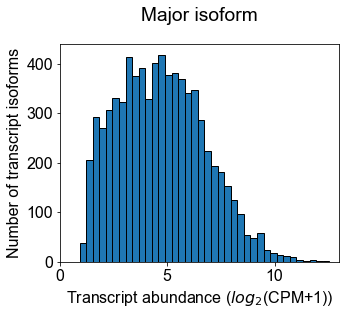

<ipython-input-6-f184bb9e13a4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_isoforms['log2cpm'] = np.log2(minor_isoforms['cpm'] + 1)


<Figure size 432x288 with 0 Axes>

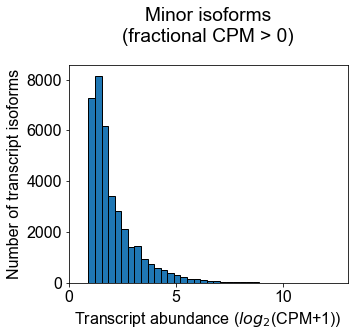

<ipython-input-6-f184bb9e13a4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_isoforms['log2cpm'] = np.log2(minor_isoforms['cpm'] + 1)


<Figure size 432x288 with 0 Axes>

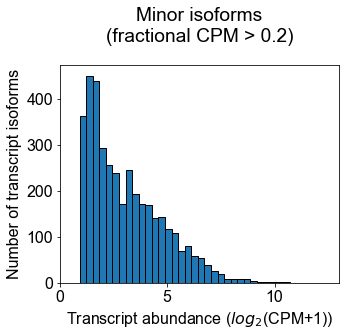

<Figure size 432x288 with 0 Axes>

In [6]:
cpm_threshold=1
over_N_cpm = sqanti_info[sqanti_info['cpm'] >= cpm_threshold]
# only do anlaysis with multi-isoform genes
over_N_cpm = over_N_cpm.groupby('gene').filter(lambda x: len(x) > 1)
# get cpm fraction of each isoform by gene
gene_cpms = over_N_cpm.groupby('gene')['cpm'].sum().reset_index()
gene_cpms.columns = ['gene', 'total_gene_cpm']
over_N_cpm = pd.merge(over_N_cpm, gene_cpms, how = 'inner', on = 'gene')
over_N_cpm['cpm_fraction'] = over_N_cpm['cpm']/over_N_cpm['total_gene_cpm']
major_isoform = appris_helper.get_major_isoform(over_N_cpm)
minor_isoforms = appris_helper.get_minor_isoforms(over_N_cpm)


def plot_s1p3_major(major_isoform):
    ## major/minor isoform transcriptional abundances
    bin_ranges = np.linspace(0,15)

    # major isoform transcriptional abundance distribution
    fig, ax = plt.subplots(figsize=(5,4))
    major_isoform['log2cpm'] = np.log2(major_isoform['cpm'] + 1)
    major_isoform['log2cpm'].hist(bins=bin_ranges, edgecolor='black')
    ax.grid(False)
    plt.xlabel("Transcript abundance ($log_2$(CPM+1))")
    plt.ylabel("Number of transcript isoforms")
    plt.xlim(0, 13)
    plt.title("Major isoform", y=1.08)
    plt.savefig('plot/FigS1.3_hist_major_isoform_abundances.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
plot_s1p3_major(major_isoform)


def plot_s1p3_minor(minor_isoforms):
    bin_ranges = np.linspace(0,15)
    # minor isoform transcriptional abundance distribution
    for cpm_frac in [0, 0.2]:
        fig, ax = plt.subplots(figsize=(5, 4))
        minor_isoforms['log2cpm'] = np.log2(minor_isoforms['cpm'] + 1)
        minor_isoforms[minor_isoforms['cpm_fraction'] > cpm_frac]['log2cpm'].hist(bins=bin_ranges, edgecolor='black')
        ax.grid(False)
        plt.xlabel("Transcript abundance ($log_2$(CPM+1))")
        plt.ylabel("Number of transcript isoforms")
        plt.xlim(0, 13)
        plt.title('Minor isoforms\n(fractional CPM > {})'.format(cpm_frac), y=1.08)
        plt.savefig(f'plot/FigS1.3_hist_minor_isoform_abundances_cpm_frac_thresh_{cpm_frac}.pdf', bbox_inches='tight')
        plt.show()
        plt.clf()
plot_s1p3_minor(minor_isoforms)